Поскольку:
1) было замечено много пропусков в столбцах Price Range и Cuisine Style, были сформированы дополнительные ноутбуки по обогащению данных с сайта. Результат данной работы представлен в файле main_task_enriched_Price_Cuisine.csv
2) также глядя на даные можно сделать вывод о ранге ресторана в данной локации, НО из этого трудно однозначно оценить как высоко ресторан находится т.к. неизвестно общее количество ресторанов локации. поэтому был сделан дополнительный ноутбук, который закачивает дополинительные данные:
- общее количество ресторанов локации
- новый ранг, поскольку с времени создания дата сета могло пройти много времени
результат этого процесса представлен в файле main_task_enriched_totcount_revcount.csv


# Загрузка Pandas и очистка данных

In [798]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
import ast 
import datetime 
warnings.simplefilter('ignore')
import grequests
from bs4 import BeautifulSoup as BS
from lxml import html
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

# Добавим метод чтобы красиво отобржать текст
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

df=  pd.read_csv('main_task_new.csv')  
#загрузим обогащенные данные по ценам и кухне
df2 = pd.read_csv('main_task_enriched_Price_Cuisine.csv')
#загрузим и обрежем обогащенные данные по рангу и общему кол-ву ресторанов в локации
df3 =pd.read_csv('main_task_enriched_totcount_revcount.csv')
df3=df3[['Ranking','tot_count']]
df3.columns=['Ranking_new','tot_count']
#Соединим данные
df=pd.concat([df[['Restaurant_id', 'City','Ranking','Rating', 'Number of Reviews','Reviews']],df2[['Price Range','Cuisine Style']],df3],axis=1)
#проведем обогажение поля Ranking_new (данные с сайта) с данными изначального датасета поскольку часть реаторанов уже закрылос и данные по ним получить не удалось
df['Ranking_new']=df.apply (lambda x : x['Ranking_new'] if pd.isna(x['Ranking_new'])==False else x['Ranking'],axis=1)


# Обработаем новые данны с сайта TripAdvisor : ранг и общее  количество ресторанов в локации 

обработаем нулевые значения общего количества ресторанов в локации и заменим их на медиану по городу

In [799]:
df[df['tot_count']==0]

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count
1532,id_1273,Stockholm,1274.0,4.5,3.0,"[[], []]",NaN,['Pub'],0.0,0.0
6577,id_10957,Paris,10959.0,4.0,3.0,"[['Impressive selection'], ['08/20/2012']]",NaN,NaN,0.0,0.0
7120,id_1334,Lyon,1332.0,5.0,4.0,"[[], []]",$,"[""French""]",0.0,0.0
7121,id_13715,Paris,13717.0,2.5,603.0,"[['Cheap price and mediocre food', 'Please do ...",$$ - $$$,"['French', 'European']",0.0,0.0
7122,id_870,Madrid,871.0,4.0,284.0,"[['Supposed to be the best steaks in Madrid', ...",$$$$,"['Steakhouse', 'Mediterranean', 'European', 'S...",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
38228,id_887,Vienna,888.0,4.0,39.0,"[['Excellent food and drink in Vienna', 'Verry...",$,"['Austrian', 'European']",0.0,0.0
38518,id_1584,Lyon,1585.0,3.5,48.0,"[[], []]",$$ - $$$,NaN,0.0,0.0
38718,id_5350,Berlin,5352.0,4.0,5.0,"[[], []]",NaN,NaN,0.0,0.0
38752,id_1441,Warsaw,1442.0,4.0,2.0,"[[], []]",$,NaN,0.0,0.0


In [800]:
city_mean=df[['City','tot_count']].dropna().groupby('City').mean().reset_index()
city_mean

,City,tot_count
0,Amsterdam,1617.803063
1,Athens,1115.894180
2,Barcelona,3935.066298
3,Berlin,2771.642720
4,Bratislava,581.410909
5,Brussels,742.533835
6,Budapest,1452.415363
7,Copenhagen,907.664207
8,Dublin,1022.407225
9,Edinburgh,829.786448


In [801]:


df['tot_count']=df.apply(lambda x: x['tot_count'] if ((pd.isna(x['tot_count'])==False) & (x['tot_count']!=0)) else city_mean[city_mean['City']==x['City']].tot_count.iloc[0] , axis=1)
df[df['tot_count'].isna()]

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count


Вычислим место ресторана в общем количестве ресторанов города

<AxesSubplot:xlabel='rank'>

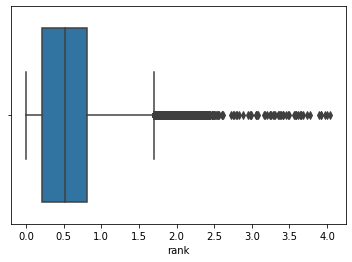

In [802]:

df['rank']=df['Ranking_new']/df['tot_count']
sns.boxplot(df['rank'])


<AxesSubplot:xlabel='rank'>

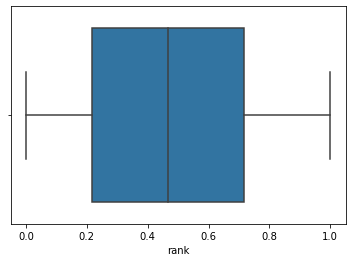

In [803]:
#уберем явно ошибочные значения, заменим на медиану посчитанную по правильным значениям
rank_mean=df[df['rank']<=1]['rank'].median()
df['rank']=df['rank'].apply(lambda x : x if x<=1 else rank_mean)
sns.boxplot(df['rank'])

# Анализ номинативных переменных


In [804]:
def get_stat_dif(df: pd.DataFrame, column: object, target='Rating') -> bool:
    '''
    Функция для проведения теста Стьюдента для номинативных и смешанных переменных
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(), 
                        df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break


#import grequests



<AxesSubplot:xlabel='City', ylabel='Rating'>

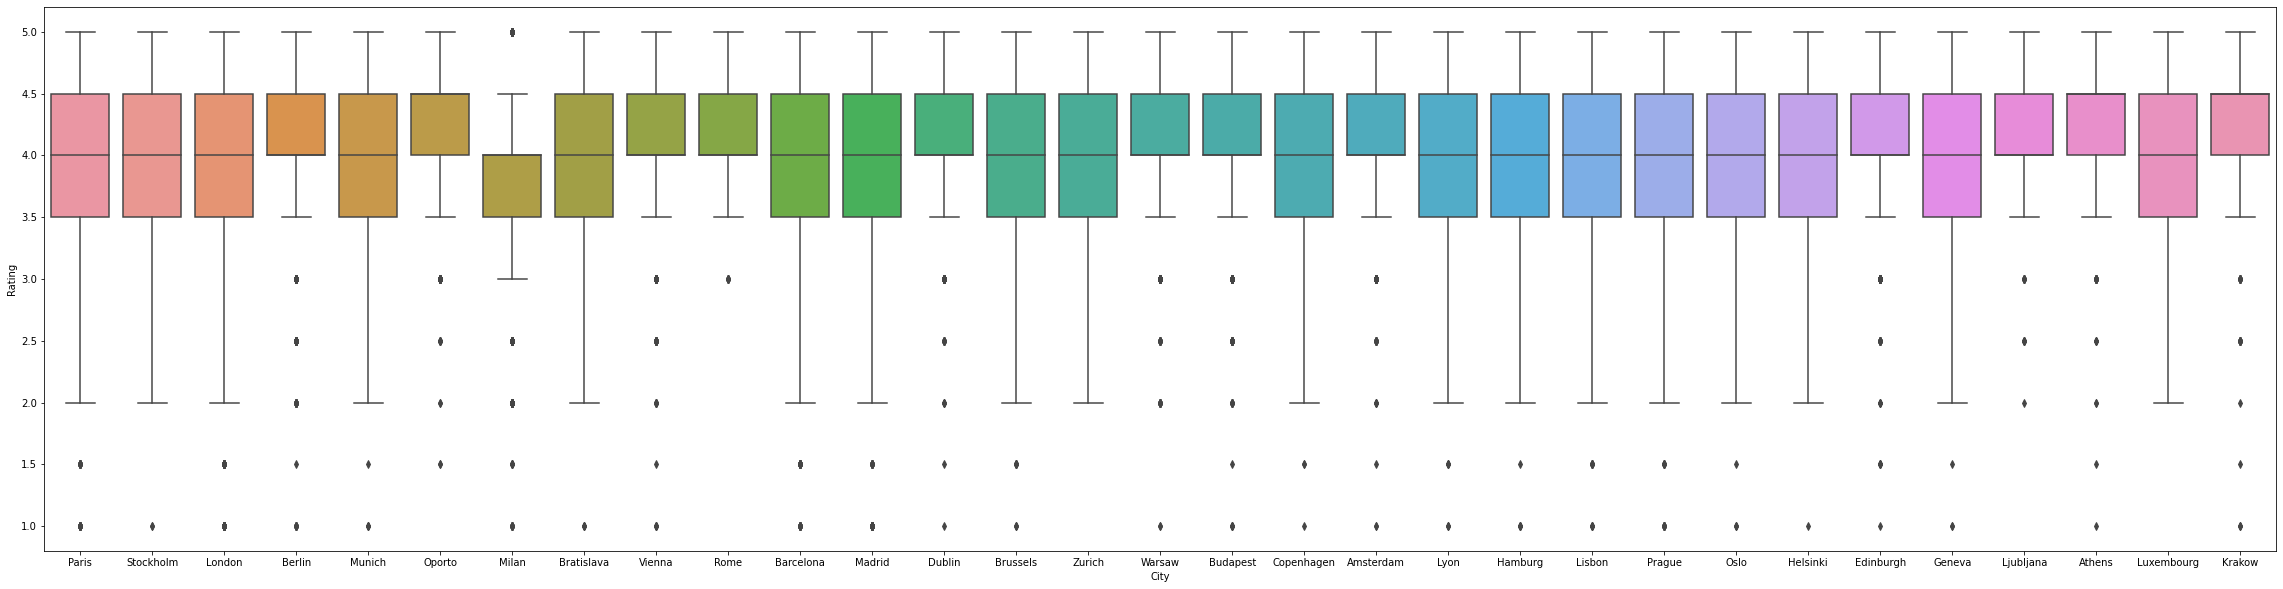

In [805]:
# посмотрим есть ли разница между разными городами
fig, ax = plt.subplots(figsize=(40, 10))
sns.boxplot(y='Rating', x='City',data=df)

In [806]:
#разложим города
def get_city (city):
    if item == city:
        return 1
    else:
            return 0
     
#сформируем полный список городов       
City_list=[]
for i in df[df['City'].isna()==False]['City']:
       if i not in City_list:
         City_list.append(i)

#добавим номинативные переменные для статистически значимых значений
for item in City_list:
 df[item]=df['City'].apply(get_city)        

#выясним какие из них являются статистически значимыми
power_city=[]
for item in City_list:
  if get_stat_dif(df,item):
      power_city.append(item)


df

Найдены статистически значимые различия для колонки Paris
Найдены статистически значимые различия для колонки Stockholm
Найдены статистически значимые различия для колонки London
Найдены статистически значимые различия для колонки Berlin
Найдены статистически значимые различия для колонки Munich
Найдены статистически значимые различия для колонки Oporto
Найдены статистически значимые различия для колонки Milan
Найдены статистически значимые различия для колонки Vienna
Найдены статистически значимые различия для колонки Rome
Найдены статистически значимые различия для колонки Barcelona
Найдены статистически значимые различия для колонки Madrid
Найдены статистически значимые различия для колонки Dublin
Найдены статистически значимые различия для колонки Brussels
Найдены статистически значимые различия для колонки Warsaw
Найдены статистически значимые различия для колонки Budapest
Найдены статистически значимые различия для колонки Amsterdam
Найдены статистически значимые различия для кол

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count,rank,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,Barcelona,Madrid,Dublin,Brussels,Zurich,Warsaw,Budapest,Copenhagen,Amsterdam,Lyon,Hamburg,Lisbon,Prague,Oslo,Helsinki,Edinburgh,Geneva,Ljubljana,Athens,Luxembourg,Krakow
0,id_5569,Paris,5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",$$ - $$$,"['European', 'French', 'International']",3172.0,6991.000000,0.453726,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1535,Stockholm,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",$$ - $$$,"[""Asian"",""Nepali""]",166.0,296.000000,0.560811,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_352,London,353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",$$$$,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",900.0,17195.000000,0.052341,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,Berlin,3458.0,5.0,3.0,"[[], []]",NaN,NaN,4493.0,5627.000000,0.798472,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,Munich,621.0,4.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",$$ - $$$,"['German', 'Central European', 'Vegetarian Fri...",655.0,2867.000000,0.228462,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,500.0,4.5,79.0,"[['The real Italian experience!', 'Wonderful f...",$$ - $$$,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",335.0,6737.000000,0.049725,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39996,id_6340,Paris,6341.0,3.5,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",$$ - $$$,"['French', 'American', 'Bar', 'European', 'Veg...",4688.0,6991.000000,0.670576,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39997,id_1649,Stockholm,1652.0,4.5,4.0,"[['Good by swedish standards', 'A hidden jewel...",NaN,"['Japanese', 'Sushi']",148.0,164.000000,0.902439,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39998,id_640,Warsaw,641.0,4.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",$$ - $$$,"['Polish', 'European', 'Eastern European', 'Ce...",181.0,748.000000,0.241979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [807]:
#проверим ушли ли какие - то города
print(len(City_list),len(power_city))

31 24


In [808]:
#сделаем новые параметр количество стилей кухни Cuisine Style
#len(ast.literal_eval (df['Cuisine Style'][0]))
df['Cuisine_count']=df['Cuisine Style'].apply(lambda x: len(ast.literal_eval (x)) if pd.isna(x)==False else 1)
df[(df['Cuisine_count']==0) & (df['Price Range']==0)]
#df['Cuisine_count'].value_counts()
df

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count,rank,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,Barcelona,Madrid,Dublin,Brussels,Zurich,Warsaw,Budapest,Copenhagen,Amsterdam,Lyon,Hamburg,Lisbon,Prague,Oslo,Helsinki,Edinburgh,Geneva,Ljubljana,Athens,Luxembourg,Krakow,Cuisine_count
0,id_5569,Paris,5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",$$ - $$$,"['European', 'French', 'International']",3172.0,6991.000000,0.453726,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,id_1535,Stockholm,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",$$ - $$$,"[""Asian"",""Nepali""]",166.0,296.000000,0.560811,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,id_352,London,353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",$$$$,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",900.0,17195.000000,0.052341,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
3,id_3456,Berlin,3458.0,5.0,3.0,"[[], []]",NaN,NaN,4493.0,5627.000000,0.798472,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,id_615,Munich,621.0,4.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",$$ - $$$,"['German', 'Central European', 'Vegetarian Fri...",655.0,2867.000000,0.228462,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,500.0,4.5,79.0,"[['The real Italian experience!', 'Wonderful f...",$$ - $$$,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",335.0,6737.000000,0.049725,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
39996,id_6340,Paris,6341.0,3.5,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",$$ - $$$,"['French', 'American', 'Bar', 'European', 'Veg...",4688.0,6991.000000,0.670576,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
39997,id_1649,Stockholm,1652.0,4.5,4.0,"[['Good by swedish standards', 'A hidden jewel...",NaN,"['Japanese', 'Sushi']",148.0,164.000000,0.902439,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
39998,id_640,Warsaw,641.0,4.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",$$ - $$$,"['Polish', 'European', 'Eastern European', 'Ce...",181.0,748.000000,0.241979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


In [809]:
def get_item (cuisine):
    if pd.isna(cuisine)==True:
        return 0
    if item in ast.literal_eval (cuisine):
        return 1
    else:
            return 0
     
 
#разложим стили кухни
cuisine_types=[]
for i in df[df['Cuisine Style'].isna()==False]['Cuisine Style']:
    for k in ast.literal_eval (i):
        if k not in cuisine_types:
          cuisine_types.append(k)

for item in cuisine_types:
 df[item]=df['Cuisine Style'].apply(get_item)

# поймем какие из них являются значимыми
                                    


df
 

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count,rank,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,Barcelona,Madrid,Dublin,Brussels,...,Romagna,Brew_Pub,Dining_bars,Polynesian,Catalan,Azerbaijani,Caucasian,Central_Asian,Afghani,Fruit_parlours,Uzbek,Neapolitan,Campania,Canadian,Beer_restaurants,Salvadoran,Yunnan,Native American,Xinjiang,Sicilian,Burmese,Fujian,Welsh,Tuscan,Latvian
0,id_5569,Paris,5570.0,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",$$ - $$$,"['European', 'French', 'International']",3172.0,6991.000000,0.453726,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1535,Stockholm,1537.0,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",$$ - $$$,"[""Asian"",""Nepali""]",166.0,296.000000,0.560811,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_352,London,353.0,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",$$$$,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",900.0,17195.000000,0.052341,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_3456,Berlin,3458.0,5.0,3.0,"[[], []]",NaN,NaN,4493.0,5627.000000,0.798472,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_615,Munich,621.0,4.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",$$ - $$$,"['German', 'Central European', 'Vegetarian Fri...",655.0,2867.000000,0.228462,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,500.0,4.5,79.0,"[['The real Italian experience!', 'Wonderful f...",$$ - $$$,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",335.0,6737.000000,0.049725,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39996,id_6340,Paris,6341.0,3.5,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",$$ - $$$,"['French', 'American', 'Bar', 'European', 'Veg...",4688.0,6991.000000,0.670576,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39997,id_1649,Stockholm,1652.0,4.5,4.0,"[['Good by swedish standards', 'A hidden jewel...",NaN,"['Japanese', 'Sushi']",148.0,164.000000,0.902439,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39998,id_640,Warsaw,641.0,4.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",$$ - $$$,"['Polish', 'European', 'Eastern European', 'Ce...",181.0,748.000000,0.241979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [810]:
#проверим являюются ли все кухни значимыми
power_cuisine_types=[]
for i in cuisine_types:
  if get_stat_dif(df,i,'Rating')==True:
    power_cuisine_types.append(i) 
print (len(cuisine_types),len(power_cuisine_types))

Найдены статистически значимые различия для колонки European
Найдены статистически значимые различия для колонки French
Найдены статистически значимые различия для колонки International
Найдены статистически значимые различия для колонки Nepali
Найдены статистически значимые различия для колонки Japanese
Найдены статистически значимые различия для колонки Sushi
Найдены статистически значимые различия для колонки Vegetarian Friendly
Найдены статистически значимые различия для колонки Vegan Options
Найдены статистически значимые различия для колонки Gluten Free Options
Найдены статистически значимые различия для колонки Central European
Найдены статистически значимые различия для колонки Bar
Найдены статистически значимые различия для колонки Portuguese
Найдены статистически значимые различия для колонки Wine_Bar
Найдены статистически значимые различия для колонки Italian
Найдены статистически значимые различия для колонки Pizza
Найдены статистически значимые различия для колонки Cafe
На

# Анализ числовых переменных

In [811]:
#вычислим сетевые рестораны и размер сети
chain=df['Restaurant_id'].value_counts()
chain=chain.reset_index()
chain.columns=['Restaurant_id','chain_count']
df=df.merge(chain, on='Restaurant_id', how='left')


In [812]:
df['chain_count'].value_counts()

1     4705
2     4634
3     3678
4     3248
9     2988
7     2688
5     2570
10    2550
8     2488
6     2478
11    2431
12    1812
13    1677
14    1036
15     555
16     288
17     102
18      72
Name: chain_count, dtype: int64

In [813]:
#стандартизуем значения поля Price Range
df['Price Range']=df['Price Range'].apply(lambda x: x if x in ['$$ - $$$', '$', '$$$$'] else '$' if x in ['Кафе','Бар','Фастфуд','Пицца','Китайская','Быстрые перекусы','Булочные','Десерты','Гастроном','Паб','Гриль'] else '$$ - $$$')

In [814]:
df['Price Range'].value_counts()

$$ - $$$    29803
$            8680
$$$$         1517
Name: Price Range, dtype: int64

In [815]:
#зделаем Price range числовым т.к. переменная имеет строгий порядок
df['Price Range']=df['Price Range'].apply(lambda x: 1 if x=='$' else 2 if x=='$$ - $$$' else 3 if x=='$$$$' else 0)

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count,rank,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,Barcelona,Madrid,Dublin,Brussels,...,Brew_Pub,Dining_bars,Polynesian,Catalan,Azerbaijani,Caucasian,Central_Asian,Afghani,Fruit_parlours,Uzbek,Neapolitan,Campania,Canadian,Beer_restaurants,Salvadoran,Yunnan,Native American,Xinjiang,Sicilian,Burmese,Fujian,Welsh,Tuscan,Latvian,chain_count
8,id_2690,Vienna,2692.0,4.0,NaN,"[[], []]",1,"[""Cafe"",""European""]",550.0,596.000000,0.922819,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
21,id_5844,Madrid,5847.0,4.0,NaN,"[[], []]",2,NaN,5847.0,4423.104433,0.465917,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
32,id_1327,Budapest,1328.0,5.0,NaN,"[['Absolutely amazing, tasty, fresh, cheap Ch....",2,NaN,1939.0,2780.000000,0.697482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
102,id_1409,Budapest,1410.0,5.0,NaN,"[[], []]",2,"['French', 'European', 'Hungarian']",1410.0,1452.415363,0.970797,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
108,id_2047,Prague,2050.0,5.0,NaN,"[[], []]",2,"['Italian', 'Mediterranean']",451.0,512.000000,0.880859,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39965,id_5720,Rome,5722.0,5.0,NaN,"[[], []]",2,NaN,8755.0,10339.000000,0.846794,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
39972,id_2009,Prague,2012.0,5.0,NaN,"[['Personal expirence'], ['10/27/2017']]",1,"['Cafe', 'Delicatessen', 'Healthy', 'Wine Bar'...",619.0,904.000000,0.684735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
39986,id_7274,Madrid,7279.0,3.0,NaN,"[[], []]",2,NaN,8484.0,10320.000000,0.822093,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
39988,id_4968,Berlin,4970.0,4.0,NaN,"[[], []]",2,NaN,4970.0,2771.642720,0.465917,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


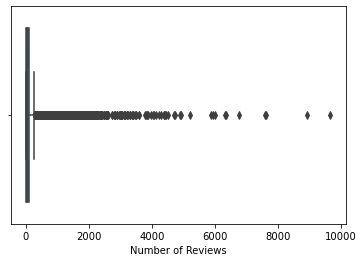

In [816]:
#узучаем поле кол- во ревью
sns.boxplot(df['Number of Reviews'])
df[df['Number of Reviews'].isna()]

Заменим пустые значения столбца Number of Reviews на медиану по городам

In [817]:
city_number=df.groupby('City')['Number of Reviews'].mean().reset_index()
#city_number=city_number.reset_index
#city_number.columns()=['City','Num_mean']
city_number.columns

Index(['City', 'Number of Reviews'], dtype='object')

In [818]:
df=df.dropna(subset=['City'])


In [819]:
#заполним пропуски медианой по городам
df['Number of Reviews']=df.apply(lambda x: x['Number of Reviews'] if pd.isna(x['Number of Reviews'])==False else city_number[city_number['City']==x['City']]['Number of Reviews'].iloc[0],axis=1)
df[df['Number of Reviews'].isna()]

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count,rank,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,Barcelona,Madrid,Dublin,Brussels,...,Brew_Pub,Dining_bars,Polynesian,Catalan,Azerbaijani,Caucasian,Central_Asian,Afghani,Fruit_parlours,Uzbek,Neapolitan,Campania,Canadian,Beer_restaurants,Salvadoran,Yunnan,Native American,Xinjiang,Sicilian,Burmese,Fujian,Welsh,Tuscan,Latvian,chain_count


In [820]:
#вытащим год последнего ревью из 'Reviews'
df['review_year']=df.Reviews.apply(lambda x:datetime.datetime.strptime(ast.literal_eval (x.replace('nan','0'))[1][0],'%m/%d/%Y').year if x!='[[], []]' else 2022)
#вычислим как давно оно было сделано относительно максимального последнего года в дата сете (считаем что это будет датой дата - сета)
df['review_year_last']=df['review_year'].max()-df['review_year']
#df.loc[df[df.review_year_last==-1].index,'review_year_last']=None
df['review_year_last']=df['review_year_last'].fillna(-1)

In [821]:
df['review_year_last'].value_counts()

5     22529
0      6471
4      4230
6      4018
7      1520
8       646
9       301
10      164
11       50
14       30
12       21
13       15
15        4
18        1
Name: review_year_last, dtype: int64

In [822]:
#приведем ранг к одному масштабу
mean_max=df.groupby('City')['Ranking'].mean().max()

In [823]:
rank_mean=df.groupby('City')['Ranking'].mean().reset_index()
rank_mean['Ranking']=rank_mean['Ranking'].apply(lambda x:mean_max/x)
rank_mean

,City,Ranking
0,Amsterdam,5.185802
1,Athens,9.304716
2,Barcelona,2.094573
3,Berlin,2.510063
4,Bratislava,18.093638
5,Brussels,5.339810
6,Budapest,6.715585
7,Copenhagen,8.411271
8,Dublin,8.334098
9,Edinburgh,9.390685


In [824]:
df['Ranking']=df.apply(lambda x: x.Ranking*rank_mean[rank_mean.City==x.City].Ranking.iloc[0],axis=1)

In [825]:
df

,Restaurant_id,City,Ranking,Rating,Number of Reviews,Reviews,Price Range,Cuisine Style,Ranking_new,tot_count,rank,Paris,Stockholm,London,Berlin,Munich,Oporto,Milan,Bratislava,Vienna,Rome,Barcelona,Madrid,Dublin,Brussels,...,Polynesian,Catalan,Azerbaijani,Caucasian,Central_Asian,Afghani,Fruit_parlours,Uzbek,Neapolitan,Campania,Canadian,Beer_restaurants,Salvadoran,Yunnan,Native American,Xinjiang,Sicilian,Burmese,Fujian,Welsh,Tuscan,Latvian,chain_count,review_year,review_year_last
0,id_5569,Paris,6586.665696,3.5,194.0,"[['Good food at your doorstep', 'A good hotel ...",2,"['European', 'French', 'International']",3172.0,6991.000000,0.453726,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2017,5
1,id_1535,Stockholm,10142.604602,4.0,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",2,"[""Asian"",""Nepali""]",166.0,296.000000,0.560811,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2017,5
2,id_352,London,353.000000,4.5,688.0,"[['Catch up with friends', 'Not exceptional'],...",3,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",900.0,17195.000000,0.052341,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2018,4
3,id_3456,Berlin,8679.798829,5.0,3.0,"[[], []]",2,NaN,4493.0,5627.000000,0.798472,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2022,0
4,id_615,Munich,3714.773548,4.0,84.0,"[['Best place to try a Bavarian food', 'Nice b...",2,"['German', 'Central European', 'Vegetarian Fri...",655.0,2867.000000,0.228462,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,2017,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,id_499,Milan,1323.124758,4.5,79.0,"[['The real Italian experience!', 'Wonderful f...",2,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",335.0,6737.000000,0.049725,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,2017,5
39996,id_6340,Paris,7498.392671,3.5,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",2,"['French', 'American', 'Bar', 'European', 'Veg...",4688.0,6991.000000,0.670576,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2017,5
39997,id_1649,Stockholm,10901.485232,4.5,4.0,"[['Good by swedish standards', 'A hidden jewel...",2,"['Japanese', 'Sushi']",148.0,164.000000,0.902439,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2016,6
39998,id_640,Warsaw,4943.571836,4.0,70.0,"[['Underground restaurant', 'Oldest Restaurant...",2,"['Polish', 'European', 'Eastern European', 'Ce...",181.0,748.000000,0.241979,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,2017,5


# проверим кореляцию числовых полей между собой

In [827]:

df[['Price Range','Rating','Number of Reviews','Ranking','review_year_last','Cuisine_count','chain_count','rank','tot_count','Ranking_new']].dropna().corr()

,Price Range,Rating,Number of Reviews,Ranking,review_year_last,Cuisine_count,chain_count,rank,tot_count,Ranking_new
Price Range,1.000000,-0.020788,0.143940,-0.109653,-0.031785,0.092710,0.077896,-0.082820,0.065056,0.023947
Rating,-0.020788,1.000000,0.029263,-0.545132,-0.018221,0.123051,0.285959,-0.338906,0.057990,-0.171530
Number of Reviews,0.143940,0.029263,1.000000,-0.386754,0.024223,0.377035,0.243495,-0.315238,0.124702,-0.117317
Ranking,-0.109653,-0.545132,-0.386754,1.000000,-0.114058,-0.528036,-0.541343,0.711114,-0.116890,0.352711
review_year_last,-0.031785,-0.018221,0.024223,-0.114058,1.000000,0.105564,0.077896,-0.109022,-0.020200,-0.066924
Cuisine_count,0.092710,0.123051,0.377035,-0.528036,0.105564,1.000000,0.345306,-0.440614,0.024533,-0.269468
chain_count,0.077896,0.285959,0.243495,-0.541343,0.077896,0.345306,1.000000,-0.405179,-0.237088,-0.477594
rank,-0.082820,-0.338906,-0.315238,0.711114,-0.109022,-0.440614,-0.405179,1.000000,-0.174471,0.302026
tot_count,0.065056,0.057990,0.124702,-0.116890,-0.020200,0.024533,-0.237088,-0.174471,1.000000,0.601565
Ranking_new,0.023947,-0.171530,-0.117317,0.352711,-0.066924,-0.269468,-0.477594,0.302026,0.601565,1.000000


 мы видим , что значимую кореляцию с целевой переменной имеют: 	Ranking	Cuisine_count	chain_count	rank, их мы и будем использовать в моделровании в первую очередь

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [828]:

df2=df[['rank','Cuisine_count','chain_count','Ranking','Price Range','Number of Reviews','review_year_last']+ ['Rating']+ City_list + cuisine_types]
df2['ones']=1



In [829]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#'review_year_last',
#X = df2.dropna()[['rank']] ,'Ranking'
#'Cuisine_count',
X = df2[['Cuisine_count','chain_count','Ranking','Price Range','ones','review_year_last','Number of Reviews']+cuisine_types+City_list]
y = df2['Rating']

In [830]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [831]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [832]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [833]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [834]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21469749999999999


# Вывод

В результате экпериментов, было установлено, что
1) добавление поля rank, как и добавление информации , загруженной с сайта негативно влияет на качество модели. Видимо , из-за временной рассинхронизации данных дата сета и сайта-  удалили из входных параметров
2) сокращения номинативных полей по городам и видам кухни - негативно вляет на качество модели. используем полную матрицу
3) слабоскоррелированные переменные Price Range , review_year_last	и Number of Reviews положительно влияют на качество и тоже включены в расчет